# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs
from scipy.sparse.linalg import norm

In [2]:
sns.set()

In [3]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [4]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балла).** Реализуйте метрику $MAP@k$.

In [5]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    r_u = np.zeros(np.array(predicted).shape)
    for i, t in enumerate(predicted):
        for j, el in enumerate(t):
            if el in relevant[i]:
                r_u[i, j] = 1.
    
    apak = np.zeros(len(predicted))
    for i, p in enumerate(predicted):
        score = 0.
        r_u_ = r_u[i, :k] if k < len(p) else r_u[i]
        p = p[:k] if len(p) > k else p
        for j in range(len(p)):
            if r_u_[j] > 0.:
                r_sum = r_u_[:j+1].sum() if j+1 < len(p) else r_u_.sum()
                score += r_sum / (j+1.)
        apak[i] = score / min(len(relevant[i]), k)
    return apak.mean()

In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [7]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [8]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [9]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [10]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [11]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [12]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [13]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [14]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [15]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        
        test_preds = [] 
        
        for user_id in self.ratings['userId'].unique():
            test_preds.append(self.recommend(user_id))
            
        all_test = self.remove_train_items(test_preds, k=k)
        return all_test

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (0.5 балла).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [16]:
def pearson(ratings: np.array, user_vector: np.array, sparse=False) -> np.array:
    lst = ratings @ user_vector
    s_1 = np.linalg.norm(user_vector) if not sparse else norm(user_vector)
    s_2 = np.linalg.norm(ratings, axis=1) if not sparse else norm(ratings, axis=1).reshape(lst.shape)
    s = lst / (s_1 * s_2)
    return s

def jaccard(ratings: np.array, user_vector: np.array, sparse=False) -> np.array:
    numerator = ratings @ user_vector
    if not sparse:
        denominator = np.sum(ratings, axis=1) + user_vector.sum() - numerator
    else:
        denominator = ratings.sum(axis=1).reshape(numerator.shape) + user_vector.sum() - numerator
    return numerator / denominator

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [542]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02
        
    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        s = self.similarity(self.R[uid])
        s_hat = np.where(s > self.alpha, s, 0.)
        s_hat = s_hat[np.arange(len(s_hat))!=uid]
        R = self.R[np.arange(len(self.R))!=uid]
        r_hat = R.T @ s_hat / (s_hat.sum() + 1e-9)
        return np.argsort(r_hat)[::-1]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [543]:
model = User2User(train_ratings, pearson)

In [544]:
pred = model.get_test_recommendations(k=10)

In [545]:
rr = []
for usr in tqdm(test_ratings['userId'].unique()):
    rr.append(test_ratings[test_ratings['userId']==usr]['trackId'].tolist())

  0%|          | 0/235 [00:00<?, ?it/s]

In [546]:
k_ = np.linspace(1, 50, 50).astype(int)
mapks_p = []
for k in tqdm(k_):
    mapks_p.append(mapk(rr, pred[test_ratings['userId'].unique()], k))

  0%|          | 0/50 [00:00<?, ?it/s]

In [547]:
model = User2User(train_ratings, jaccard)

In [548]:
pred = model.get_test_recommendations(k=10)

In [549]:
k_ = np.linspace(1, 50, 50).astype(int)
mapks_j = []
for k in tqdm(k_):
    mapks_j.append(mapk(rr, pred[test_ratings['userId'].unique()], k))

  0%|          | 0/50 [00:00<?, ?it/s]

In [573]:
rand = np.random.randint(0, tracks_info.shape[0], size=pred.shape)

In [574]:
mapks_random = []
for k in tqdm(k_):
    mapks_random.append(mapk(rr, rand[test_ratings['userId'].unique()], k))

  0%|          | 0/50 [00:00<?, ?it/s]

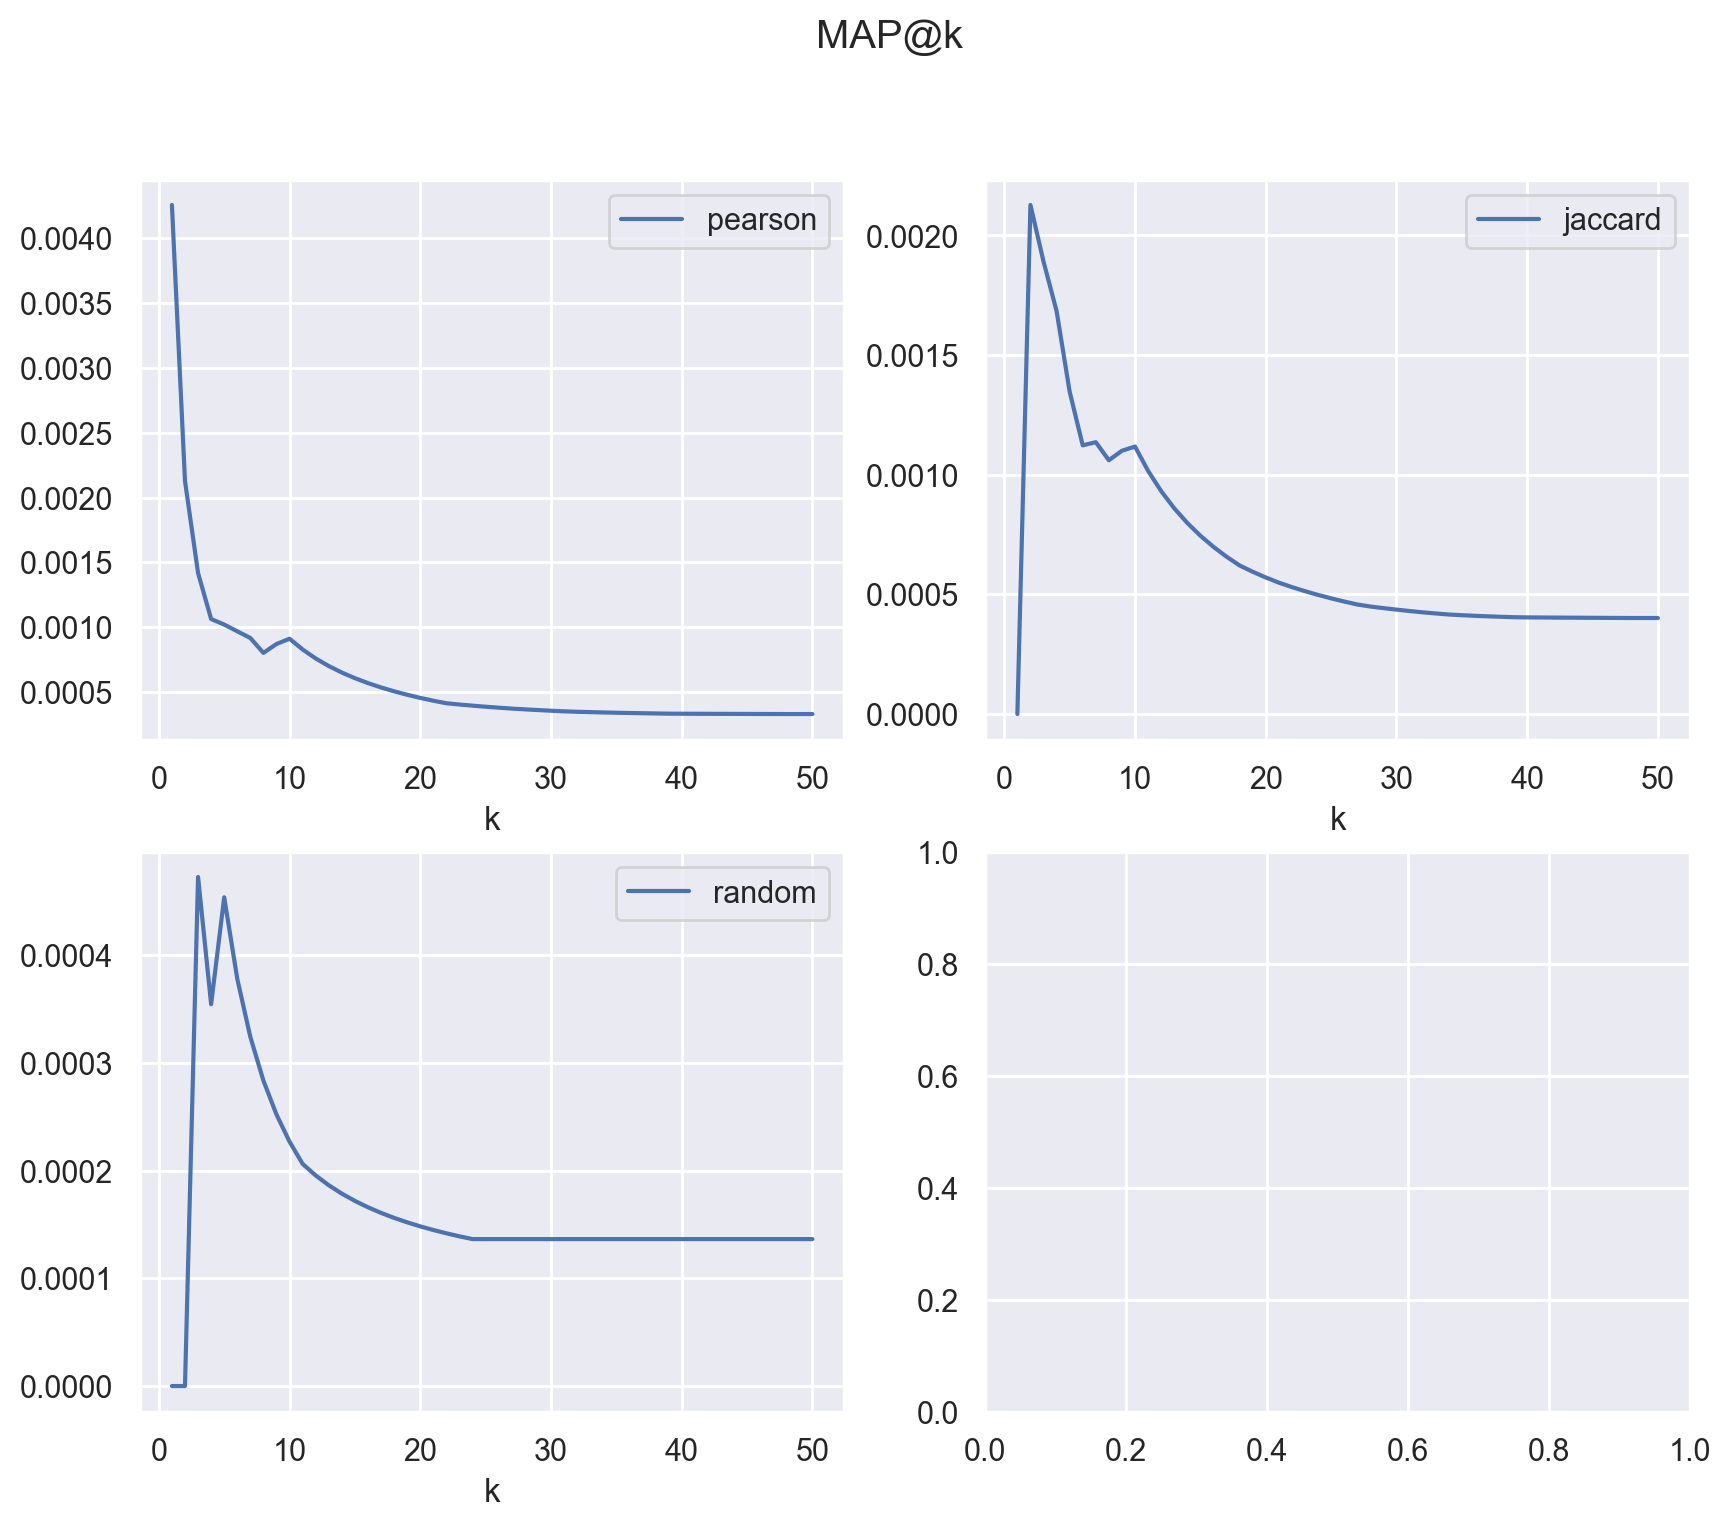

In [577]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=200)
fig.suptitle('MAP@k')
axs[0][0].set_xlabel('k')
axs[0][1].set_xlabel('k')
axs[1][0].set_xlabel('k')
axs[0][0].plot(k_, mapks_p, label='pearson')
axs[0][1].plot(k_, mapks_j, label='jaccard')
axs[1][0].plot(k_, mapks_random, label='random')
axs[1][0].legend()
axs[0][0].legend()
axs[0][1].legend();

Вывод такой: user2user алгоритм очень плохо отрабатывает, он лучше случайного только в том случае, если нам нужно составить рекомендации из отноносительно большого числа треков

**Бонус (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [26]:
class BaseModel_sparse:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        self.R = scs.csr_array(self.R, dtype=float)
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
            
        return new_preds

    def get_test_recommendations(self, k: int):
        
        test_preds = [] 
        
        for user_id in tqdm(self.ratings['userId'].unique()):
            test_preds.append(self.recommend(user_id))
            
        all_test = self.remove_train_items(test_preds, k=k)
        return all_test

In [551]:
class User2User_sparse(BaseModel_sparse):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02
        
    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        
        return self.similarity_func(self.R, user_vector, sparse=True)

    def recommend(self, uid: int):
        s = self.similarity(self.R[[uid], :].T)
        s_hat = np.where(s > self.alpha, s, 0.)
        s_hat = s_hat[np.arange(len(s_hat))!=uid]
        s_hat = scs.csr_array(s_hat, dtype=float)
        R = self.R[np.arange(self.R.shape[0])!=uid]
        M = R.T @ s_hat
        r_hat = (R.T @ s_hat).todense() / (s_hat.sum()+1e-9)
        return np.argsort(r_hat.ravel())[::-1]

In [552]:
model_s = User2User_sparse(train_ratings, pearson)

In [553]:
pred_s = model_s.get_test_recommendations(k=10)

  0%|          | 0/241 [00:00<?, ?it/s]

In [554]:
k_ = np.linspace(1, 50, 50).astype(int)
smapks_p = []
for k in tqdm(k_):
    smapks_p.append(mapk(rr, pred_s[test_ratings['userId'].unique()], k))

  0%|          | 0/50 [00:00<?, ?it/s]

In [555]:
model_s = User2User_sparse(train_ratings, jaccard)

In [556]:
pred_s = model_s.get_test_recommendations(k=10)

  0%|          | 0/241 [00:00<?, ?it/s]

In [557]:
k_ = np.linspace(1, 50, 50).astype(int)
smapks_j = []
for k in tqdm(k_):
    smapks_j.append(mapk(rr, pred_s[test_ratings['userId'].unique()], k))

  0%|          | 0/50 [00:00<?, ?it/s]

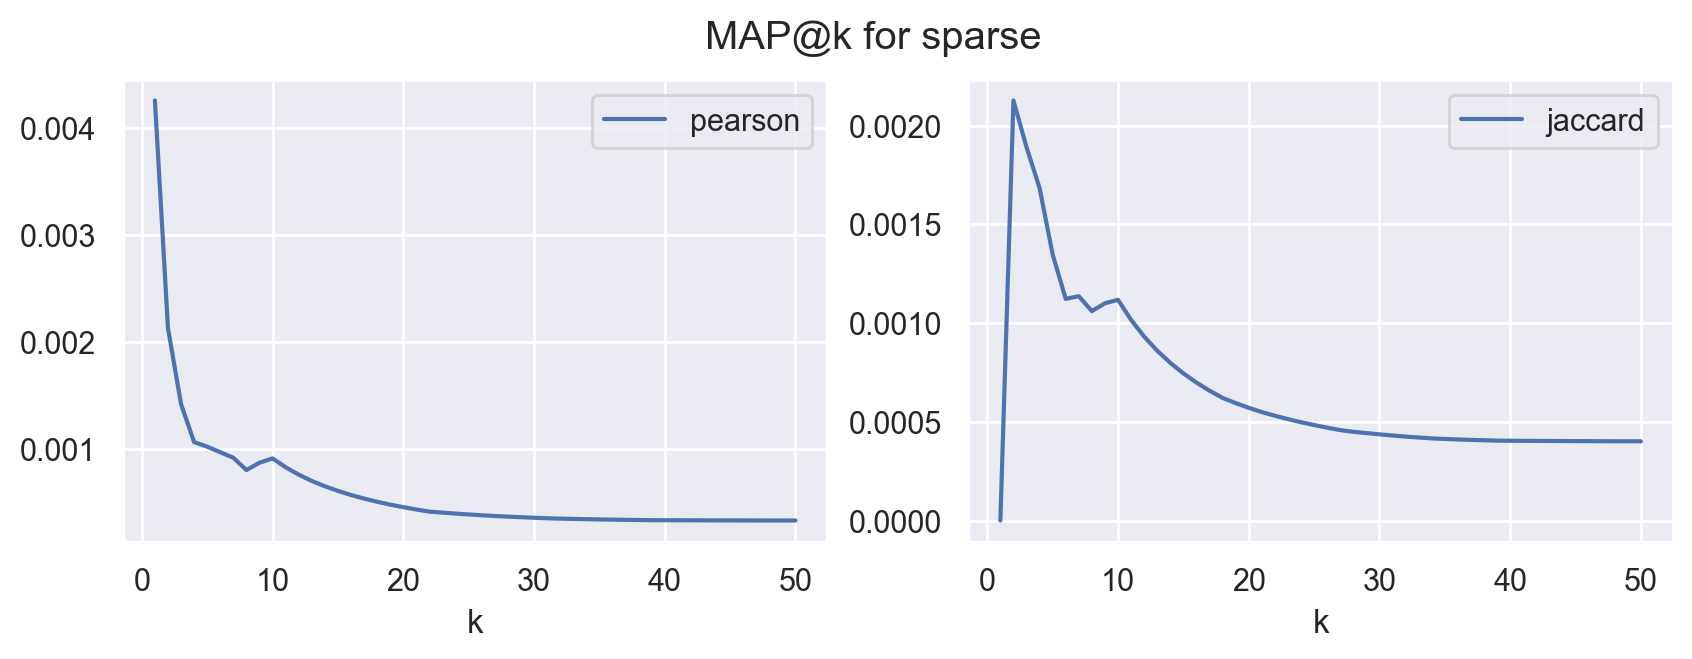

In [558]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi=200)
fig.suptitle('MAP@k for sparse')
axs[0].set_xlabel('k')
axs[1].set_xlabel('k')
axs[0].plot(k_, smapks_p, label='pearson')
axs[1].plot(k_, smapks_j, label='jaccard')
axs[0].legend()
axs[1].legend();

С помощью разреженных матриц стало работать быстрее в ~20 раз

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [35]:
user_id = np.random.randint(0, model.n_users)

In [36]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
11,Long Tall Sally,['Little Richard']
73,The Greatest,['Cat Power']
164,My Favourite Game,['The Cardigans']
189,Sweet Home Alabama,['Lynyrd Skynyrd']
258,What A Wonderful World,['Louis Armstrong']
303,I'm A Believer,['Smash Mouth']
414,Johnny B. Goode,"['Marty McFly', 'The Starlighters']"
467,Joker & the Thief,['Wolfmother']
474,Tom's Diner,"['DNA', 'Suzanne Vega', 'Nick Batt', 'Neal Sla..."
519,Erase / Rewind,['The Cardigans']


In [578]:
preds = model_s.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

  0%|          | 0/241 [00:00<?, ?it/s]

Predicted tracks:


,name,artists
22073,Midnight City,['M83']
3106,Can't Stop,['Red Hot Chili Peppers']
6376,"You're Gonna Go Far, Kid",['The Offspring']
1081,Come As You Are,['Nirvana']
15419,Nightcall,['Kavinsky']
22228,Dust It Off,['The Dø']
20094,Come And Get Your Love,['Redbone']
27345,Lemon Tree,"[""Fool's Garden""]"
24859,House of the Rising Sun,['Animals']
2555,Californication,['Red Hot Chili Peppers']


In [579]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
21763,First Step,['Hans Zimmer']
22663,Silent Moon,['Jia Peng Fang']
22990,Fairly Local,['twenty one pilots']
23254,All We Do,['Oh Wonder']
23429,Stressed Out,['twenty one pilots']
23614,Doubt,['twenty one pilots']
23616,Message Man,['twenty one pilots']
23617,Hometown,['twenty one pilots']
24229,Freedom,['Pharrell Williams']
24500,Way Down We Go,['KALEO']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 6 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

Ответ:\
$L=(PQ^T-R)^2+\lambda(P^2+Q^2)$\
Для $P$:\
$\frac{\partial L}{\partial P}=2(PQ^T-R)Q+2\lambda P$\
Для $Q$:\
$\frac{\partial L}{\partial Q}=2(PQ^T-R)^TP+2\lambda Q=2(QP^T-R^T)P+2\lambda Q$


\
**ALS:**

Ответ:\
$2(PQ^T-R)Q+2\lambda P=0\longrightarrow P=RQ(Q^TQ+\lambda I)^{-1}$\
$2(QP^T-R^T)P+2\lambda Q=0\longrightarrow P=R^TP(P^TP+\lambda I)^{-1}$


**Задание 7 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [462]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

    def fit(self, num_iters=5, lr=1e-4, lamb=1e-2):
        
        for epoch in range(num_iters):

            if self.mode == 'sgd':
                grad_L_P = 2*(self.P @ self.Q.T - self.R) @ self.Q + 2*lamb*self.P
                grad_L_Q =  2*(self.Q @ self.P.T - self.R.T) @ self.P + 2*lamb*self.Q
                self.P = self.P - lr*grad_L_P
                self.Q = self.Q - lr*grad_L_Q

            elif self.mode == 'als':
                self.P = self.R @ self.Q @ np.linalg.inv(self.Q.T @ self.Q+lamb * np.eye(self.dim))
                self.Q = self.R.T @ self.P @ np.linalg.inv(self.P.T @ self.P+lamb * np.eye(self.dim))

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [516]:
model_m_sgd = HiddenVars(train_ratings, dim=150)
model_m_sgd.fit(num_iters=5, lr=2e-4, lamb=1e1)

In [517]:
pred_m_sgd = model_m_sgd.get_test_recommendations(k=5)

In [518]:
smapks_sgd = []
for k in tqdm(k_):
    smapks_sgd.append(mapk(rr, pred_m_sgd[test_ratings['userId'].unique()], k))

  0%|          | 0/50 [00:00<?, ?it/s]

In [471]:
model_m_als = HiddenVars(train_ratings, mode='als', dim=90)
model_m_als.fit(num_iters=10, lamb=1e-1)

In [472]:
pred_m_als = model_m_als.get_test_recommendations(k=5)

In [473]:
k_ = np.linspace(1, 50, 50).astype(int)
smapks_als = []
for k in tqdm(k_):
    smapks_als.append(mapk(rr, pred_m_als[test_ratings['userId'].unique()], k))

  0%|          | 0/50 [00:00<?, ?it/s]

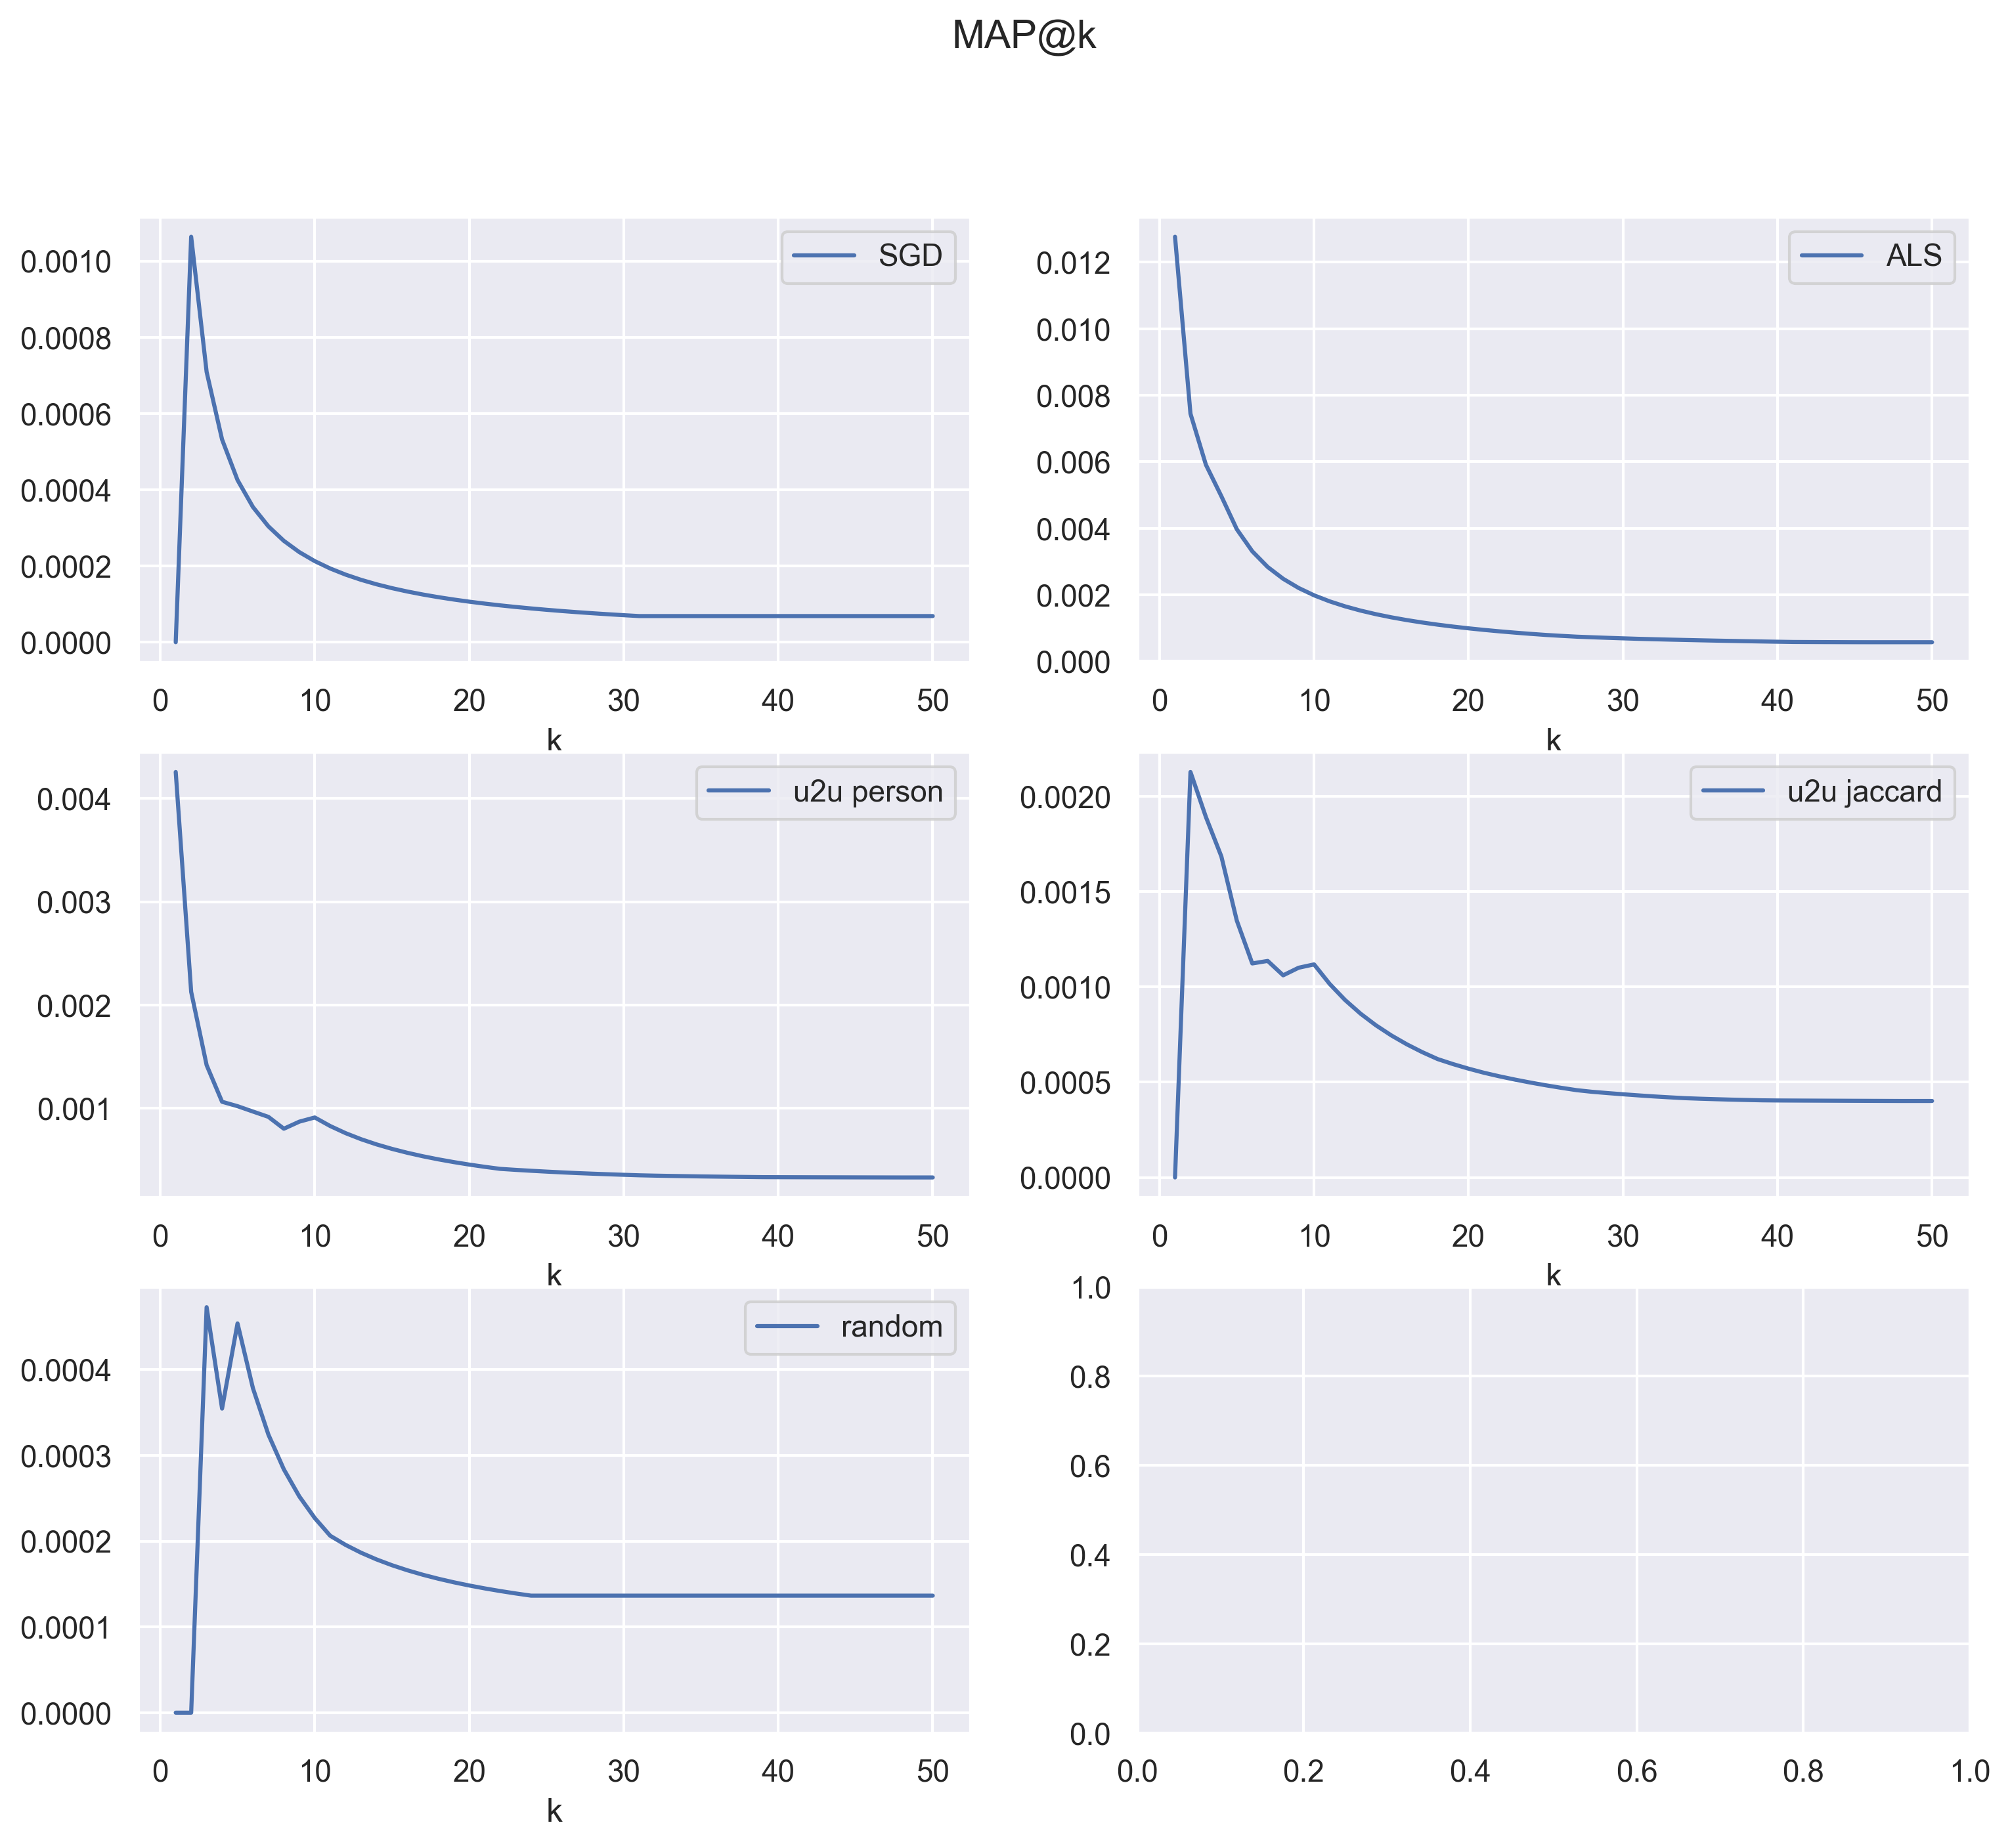

In [588]:
fig2, axs2 = plt.subplots(3, 2, figsize=(12, 10), dpi=300)
fig2.suptitle('MAP@k')
axs2[0][0].set_xlabel('k')
axs2[0][1].set_xlabel('k')
axs2[1][0].set_xlabel('k')
axs2[1][1].set_xlabel('k')
axs2[2][0].set_xlabel('k')
axs2[0][0].plot(k_, smapks_sgd, label='SGD')
axs2[0][1].plot(k_, smapks_als, label='ALS')
axs2[1][0].plot(k_, smapks_p, label='u2u person')
axs2[1][1].plot(k_, smapks_j, label='u2u jaccard')
axs2[2][0].plot(k_, mapks_random, label='random')
axs2[0][0].legend()
axs2[0][1].legend()
axs2[1][0].legend()
axs2[1][1].legend()
axs2[2][0].legend();

Ну по метрикам очевидно ALS выигрывает в начале, а дальше user2user будут получше, так что я бы комбинировал их, скажем, первые пару треков предсказывал через ALS, остальные, скажем, 20, через u2u.
Не вижу особого смысла играться с SGD - для него как-то больно подбирать параметры(то он разойдется, то просто сойдется плохо) - тут скорее не параметры у SGD подбирать надо, а метод оптимизации другой брать.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [521]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model_m_als.Q @ model_m_als.Q[example_trackId]
preds = preds / np.sqrt((model_m_als.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [522]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model_m_als.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.666240
2179,Восьмиклассница,['КИНО'],0.641221
5230,Call Me When You're Sober,['Evanescence'],0.560398
14871,Никто не услышит (Ой-йо),['ЧайФ'],0.553064
12475,Colorblind,['Counting Crows'],0.552256
16295,Push the Sky Away,['Nick Cave & The Bad Seeds'],0.552256
17795,Георгины,['АлоэВера'],0.552256
17794,Несуразная,['АлоэВера'],0.552256
8407,Последняя поэма,['Алексей Рыбников'],0.552256


In [540]:
example_trackId = tracks_info[tracks_info.name == 'Witchcraft'].iloc[0].id

preds = model_m_sgd.Q @ model_m_sgd.Q[example_trackId]
preds = preds / np.sqrt((model_m_sgd.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [541]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model_m_sgd.Q[example_trackId])
similar_tracks

,name,artists,similarity
5709,Witchcraft,['Pendulum'],1.000000
34176,"Together, Wherever",['Sarah Where Is My Tea'],0.937029
23633,Tell Me Something I Don't Know,['Selena Gomez'],0.927174
4440,Jump,['Van Halen'],0.926235
25513,Sin Contrato,['Maluma'],0.924497
56412,Amsterdam,['Super Monkeys'],0.923160
16624,Gypsy Woman,['Crystal Waters'],0.922097
17001,Creep,"['Clint Mansell', 'Eliot Sumner']",0.912080
47196,Familiar,"['Steven Universe', 'Zach Callison']",0.911105
56775,Whoop Tang Flow,"['Theophilus London', 'Raekwon']",0.909994
